# The Sydney Weather Data

Import library

In [1]:
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.metrics import normalized_mutual_info_score
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn import metrics
import math

# Recorded Weather Condition for Sydney

In [2]:
syd_data = pd.read_csv('/course/data/a2/weather/weather_sydney.csv')
syd_data.head()

,Date,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Direction of maximum wind gust,Speed of maximum wind gust (km/h),Time of maximum wind gust,9am Temperature (°C),...,9am cloud amount (oktas),9am wind direction,9am wind speed (km/h),9am MSL pressure (hPa),3pm Temperature (°C),3pm relative humidity (%),3pm cloud amount (oktas),3pm wind direction,3pm wind speed (km/h),3pm MSL pressure (hPa)
0,2021-02-1,20.7,28.9,0.8,0.4,6.8,NNE,44.0,17:26,22.1,...,7.0,S,7,1016.1,28.3,68,1,ESE,17,1012.3
1,2021-02-2,17.5,25.8,17.4,7.6,5.9,SSW,43.0,04:49,19.1,...,7.0,SW,17,1010.5,23.2,60,2,SE,24,1010.5
2,2021-02-3,17.5,25.8,5.0,7.8,9.3,S,31.0,09:10,19.4,...,1.0,SSW,15,1013.7,24.7,56,5,ESE,17,1012.6
3,2021-02-4,17.9,28.9,0.0,6.8,10.1,NE,48.0,13:58,21.5,...,6.0,,Calm,1013.4,27.7,62,5,NE,30,1010.0
4,2021-02-5,20.8,28.3,0.0,8.4,11.2,NE,54.0,12:25,23.5,...,2.0,NE,17,1012.1,28.1,71,2,NE,33,1009.0


In [3]:
syd_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424 entries, 0 to 423
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Date                               424 non-null    object 
 1   Minimum temperature (°C)           424 non-null    float64
 2   Maximum temperature (°C)           423 non-null    float64
 3   Rainfall (mm)                      424 non-null    float64
 4   Evaporation (mm)                   418 non-null    float64
 5   Sunshine (hours)                   422 non-null    float64
 6   Direction of maximum wind gust     417 non-null    object 
 7   Speed of maximum wind gust (km/h)  417 non-null    float64
 8   Time of maximum wind gust          417 non-null    object 
 9   9am Temperature (°C)               424 non-null    float64
 10  9am relative humidity (%)          424 non-null    int64  
 11  9am cloud amount (oktas)           423 non-null    float64

Summary:
- The weather data does not have many data missing and have non-null cell in the dataframe.

# The Demand For New South Wales

In [4]:
demand = pd.read_csv('/course/data/a2/weather/price_demand_data.csv')
nsw_demand = demand[demand['REGION'] == 'NSW1']
nsw_demand.head()

,REGION,SETTLEMENTDATE,TOTALDEMAND,PRICESURGE
0,NSW1,2021/02/01 00:30:00,6693.67,False
1,NSW1,2021/02/01 01:00:00,6511.88,False
2,NSW1,2021/02/01 01:30:00,6275.03,False
3,NSW1,2021/02/01 02:00:00,6121.26,False
4,NSW1,2021/02/01 02:30:00,6123.13,False


In [5]:
nsw_demand.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60000 entries, 0 to 225311
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   REGION          60000 non-null  object 
 1   SETTLEMENTDATE  60000 non-null  object 
 2   TOTALDEMAND     60000 non-null  float64
 3   PRICESURGE      60000 non-null  bool   
dtypes: bool(1), float64(1), object(2)
memory usage: 1.9+ MB


Summary:
- The demand for New South Wales does not contain the null cells and the does not have missing.

## Pre-processing the New South Wales Demand  

In [6]:
#Make the nsw_demand have the date cell using regex
date_pattern = r'(\d{4}\/\d{2}\/\d{1,2})'

#apply it to the demand dataframe
nsw_demand['Date'] = nsw_demand['SETTLEMENTDATE'].str.extract(date_pattern)
nsw_demand['Date'] = pd.to_datetime(nsw_demand['Date'])

#create the diff_time columns to make the difference in time between two record of energy demand
nsw_demand["diff_time"] = pd.to_datetime(nsw_demand['SETTLEMENTDATE']).diff(periods = 1).dt.total_seconds()
#replace the first cell in diff time to 1800 seconds
nsw_demand["diff_time"] = nsw_demand["diff_time"].replace(np.nan, 1800)

#we calculate the consumption and change it to MWH:
nsw_demand['CONSUMPTION'] = nsw_demand['TOTALDEMAND']*nsw_demand["diff_time"]
nsw_demand['CONSUMPTION'] = nsw_demand['CONSUMPTION']*(1e6)*(2.7777e-10)

nsw_demand.head()

C:\Users\Kevin\AppData\Local\Temp\ipykernel_2092\4259070656.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nsw_demand['Date'] = nsw_demand['SETTLEMENTDATE'].str.extract(date_pattern)
C:\Users\Kevin\AppData\Local\Temp\ipykernel_2092\4259070656.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nsw_demand['Date'] = pd.to_datetime(nsw_demand['Date'])
C:\Users\Kevin\AppData\Local\Temp\ipykernel_2092\4259070656.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

,REGION,SETTLEMENTDATE,TOTALDEMAND,PRICESURGE,Date,diff_time,CONSUMPTION
0,NSW1,2021/02/01 00:30:00,6693.67,False,2021-02-01,1800.0,3346.741289
1,NSW1,2021/02/01 01:00:00,6511.88,False,2021-02-01,1800.0,3255.848834
2,NSW1,2021/02/01 01:30:00,6275.03,False,2021-02-01,1800.0,3137.427150
3,NSW1,2021/02/01 02:00:00,6121.26,False,2021-02-01,1800.0,3060.544302
4,NSW1,2021/02/01 02:30:00,6123.13,False,2021-02-01,1800.0,3061.479276


## Plot the daily Consumption

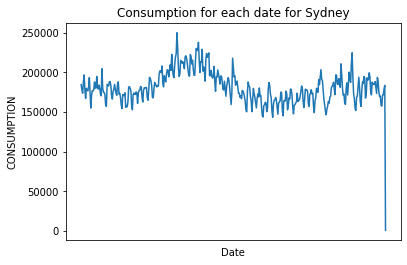

In [7]:
#plot the average demand for each date for nsw
#create a subplot
plt.rcParams["figure.figsize"] = (10,10)
fig, ax = plt.subplots()

nsw_date_demand = nsw_demand.groupby('Date').sum()
nsw_date_demand = nsw_date_demand.reset_index()

#plot the bar plot
ax.plot([str(x) for x in nsw_date_demand.index], nsw_date_demand['CONSUMPTION'])

#add lable and title
ax.set_xlabel('Date')
ax.set_ylabel('CONSUMPTION')
ax.set_title('Consumption for each date for Sydney')
plt.xticks([])
plt.show()
plt.close()

- There is an outliner which is the last date in the demand which did not record the whole date. Therefore, we replace that with the mean value of the consumption.

In [8]:
nsw_date_demand['CONSUMPTION'][nsw_date_demand['CONSUMPTION'].idxmin()] = nsw_date_demand.mean()["CONSUMPTION"]

C:\Users\Kevin\AppData\Local\Temp\ipykernel_2092\4048731520.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  nsw_date_demand['CONSUMPTION'][nsw_date_demand['CONSUMPTION'].idxmin()] = nsw_date_demand.mean()["CONSUMPTION"]
C:\Users\Kevin\AppData\Local\Temp\ipykernel_2092\4048731520.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nsw_date_demand['CONSUMPTION'][nsw_date_demand['CONSUMPTION'].idxmin()] = nsw_date_demand.mean()["CONSUMPTION"]


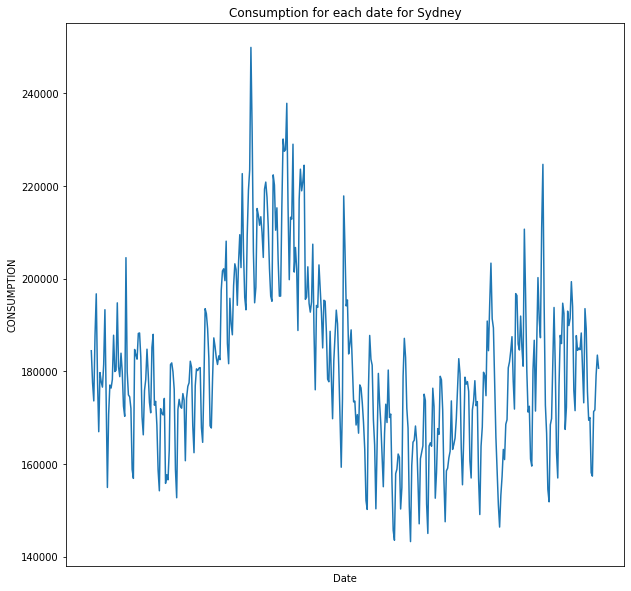

In [9]:
#plot the average demand for each date for nsw
#create a subplot
plt.rcParams["figure.figsize"] = (10,10)
fig, ax = plt.subplots()

#plot the bar plot
ax.plot([str(x) for x in nsw_date_demand.index], nsw_date_demand['CONSUMPTION'])

#add lable and title
ax.set_xlabel('Date')
ax.set_ylabel('CONSUMPTION')
ax.set_title('Consumption for each date for Sydney')
plt.xticks([])
plt.show()
plt.close()

# Merging the Sydney weather dataset and the NSW demand dataset and pre-processing the merged_data

## Performing merging and pre_processing

In [10]:
#this function will change the direction in to 1-16 (numeric the direction)
def numeric_wind_direction(name_col, weather_data):
    weather_data[name_col] = OrdinalEncoder().fit_transform(weather_data[[name_col]])

- Because the demand for VIC per day has less row than the weather data for the melboure, we merge the weather data to the demand data to keep more data as possible


In [11]:
#change the type of Date columns into datetime before mergeing
syd_data['Date'] = pd.to_datetime(syd_data['Date'])

#merge the demand to the weather dataset
original_merged_data = pd.merge(syd_data, nsw_date_demand, how='left')



#numric the direction of the wind
numeric_wind_direction('Direction of maximum wind gust ',original_merged_data)
numeric_wind_direction('9am wind direction',original_merged_data)
numeric_wind_direction('3pm wind direction',original_merged_data)

#convert the time in maximum wind gust to the total seconds
original_merged_data['Time of maximum wind gust'] = '00:' + original_merged_data['Time of maximum wind gust']
original_merged_data['Time of maximum wind gust'] = pd.to_timedelta(original_merged_data['Time of maximum wind gust']).dt.total_seconds()

#change the Calm value in the dataframe to np.nan
original_merged_data = original_merged_data.replace([np.nan, np.inf, -np.inf, 'Calm'], np.nan)

#because as we obsevered the Dtype of wind speed is an object
#so we change it into float64 which will be identical for fillna working
original_merged_data['9am wind speed (km/h)'] = original_merged_data['9am wind speed (km/h)'].astype(np.float64)
original_merged_data['3pm wind speed (km/h)'] = original_merged_data['3pm wind speed (km/h)'].astype(np.float64)

#fill the nan value in the wind direction by the mode value 
#rather than the mean value in those weather condition
original_merged_data['9am wind direction'] = original_merged_data['9am wind direction'].fillna(original_merged_data['9am wind direction'].mode())
original_merged_data['3pm wind direction'] = original_merged_data['3pm wind direction'].fillna(original_merged_data['9am wind direction'].mode())
original_merged_data['Direction of maximum wind gust '] = original_merged_data['Direction of maximum wind gust '].fillna(original_merged_data['Direction of maximum wind gust '].mode())

#fill the nan value with the mean value for the rest of the weather condition
original_merged_data = original_merged_data.fillna(original_merged_data.mean())

# we reset the index
original_merged_data = original_merged_data.reset_index()
original_merged_data = original_merged_data.drop(['index'], axis=1)

original_merged_data.head()

C:\Users\Kevin\AppData\Local\Temp\ipykernel_2092\1671445566.py:33: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  original_merged_data = original_merged_data.fillna(original_merged_data.mean())


,Date,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Direction of maximum wind gust,Speed of maximum wind gust (km/h),Time of maximum wind gust,9am Temperature (°C),...,3pm Temperature (°C),3pm relative humidity (%),3pm cloud amount (oktas),3pm wind direction,3pm wind speed (km/h),3pm MSL pressure (hPa),TOTALDEMAND,PRICESURGE,diff_time,CONSUMPTION
0,2021-02-01,20.7,28.9,0.8,0.4,6.8,5.0,44.0,1046.0,22.1,...,28.3,68,1,3.0,17.0,1012.3,368948.08,0.0,84600.0,184468.874727
1,2021-02-02,17.5,25.8,17.4,7.6,5.9,11.0,43.0,289.0,19.1,...,23.2,60,2,10.0,24.0,1010.5,355162.09,0.0,86400.0,177576.072731
2,2021-02-03,17.5,25.8,5.0,7.8,9.3,8.0,31.0,550.0,19.4,...,24.7,56,5,3.0,17.0,1012.6,347299.42,0.0,86400.0,173644.847808
3,2021-02-04,17.9,28.9,0.0,6.8,10.1,4.0,48.0,838.0,21.5,...,27.7,62,5,5.0,30.0,1010.0,375599.02,0.0,86400.0,187794.251614
4,2021-02-05,20.8,28.3,0.0,8.4,11.2,4.0,54.0,745.0,23.5,...,28.1,71,2,5.0,33.0,1009.0,393493.57,0.0,86400.0,196741.276090


## Drop the weather condition at particular time which is not corresponse for finding the correlation with the total daily consumption

In [12]:
drop_feature = []

for col in original_merged_data:
    if "9am" in col or "3pm" in col:
        drop_feature.append(col)
        
consumption_merged_data = original_merged_data.drop(columns = drop_feature, axis = 1)

#we also need to drop out the other unrelated feature
consumption_merged_data = consumption_merged_data.drop(['PRICESURGE','TOTALDEMAND', 'diff_time', 'Date'], axis=1)

consumption_merged_data.head()

,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Direction of maximum wind gust,Speed of maximum wind gust (km/h),Time of maximum wind gust,CONSUMPTION
0,20.7,28.9,0.8,0.4,6.8,5.0,44.0,1046.0,184468.874727
1,17.5,25.8,17.4,7.6,5.9,11.0,43.0,289.0,177576.072731
2,17.5,25.8,5.0,7.8,9.3,8.0,31.0,550.0,173644.847808
3,17.9,28.9,0.0,6.8,10.1,4.0,48.0,838.0,187794.251614
4,20.8,28.3,0.0,8.4,11.2,4.0,54.0,745.0,196741.276090


# Plot the Pearson correlation between each attribute in the merged dataframe 

In [13]:
corr = consumption_merged_data.corr()
corr.style.background_gradient(cmap='coolwarm')

,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Direction of maximum wind gust,Speed of maximum wind gust (km/h),Time of maximum wind gust,CONSUMPTION
Minimum temperature (°C),1.000000,0.717759,0.246827,0.216090,-0.169071,-0.471812,0.134320,0.265106,-0.339124
Maximum temperature (°C),0.717759,1.000000,-0.035722,0.159202,0.347998,-0.371221,-0.037562,0.297127,-0.434081
Rainfall (mm),0.246827,-0.035722,1.000000,-0.021046,-0.340821,-0.096040,0.298622,-0.015490,0.019484
Evaporation (mm),0.216090,0.159202,-0.021046,1.000000,0.016785,-0.074986,0.127418,0.083331,-0.178895
Sunshine (hours),-0.169071,0.347998,-0.340821,0.016785,1.000000,0.074017,-0.119534,0.041994,-0.229631
Direction of maximum wind gust,-0.471812,-0.371221,-0.096040,-0.074986,0.074017,1.000000,0.183260,-0.276284,0.186951
Speed of maximum wind gust (km/h),0.134320,-0.037562,0.298622,0.127418,-0.119534,0.183260,1.000000,0.200880,-0.080805
Time of maximum wind gust,0.265106,0.297127,-0.015490,0.083331,0.041994,-0.276284,0.200880,1.000000,-0.123010
CONSUMPTION,-0.339124,-0.434081,0.019484,-0.178895,-0.229631,0.186951,-0.080805,-0.123010,1.000000


- By observing the correlation between the CONSUMPTION and each weather condition, it turns out there is no correlation between the CONSUMPTION and the weather conditon by using Pearson Correlation.

## Reason for uncorrelation between some weather condition and consumption 

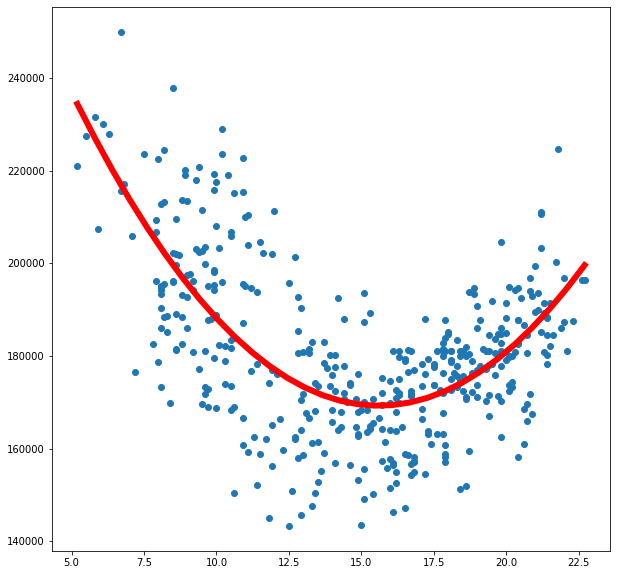

In [14]:
#create a subplot
plt.rcParams["figure.figsize"] = (10,10)
fig, ax = plt.subplots()

ax.scatter(consumption_merged_data['Minimum temperature (°C)'], consumption_merged_data['CONSUMPTION'])
z = np.polyfit(consumption_merged_data['Minimum temperature (°C)'], consumption_merged_data['CONSUMPTION'],2)
curve = np.array(z)
x = np.linspace(min(consumption_merged_data['Minimum temperature (°C)']),max(consumption_merged_data['Minimum temperature (°C)']),30)
y = [np.polyval(curve, i) for i in x]
ax.plot(x,y, 'r', linewidth = 6)

plt.show()
plt.close()

- The relation between the weather condition and consumption does not a linear relation so that the pearson method can not detect the relationship between them

## Observed the correlation in Normalized Mutual Information method

In [15]:
equal_width = KBinsDiscretizer(n_bins=20, encode='ordinal', strategy='uniform')
#plot the discrete data 
discrete_data = consumption_merged_data.copy()
for name in consumption_merged_data:
    
    discrete_data[name] = equal_width.fit_transform(consumption_merged_data[[name]])

corr = discrete_data.corr(method=normalized_mutual_info_score)
corr.style.background_gradient(cmap='coolwarm')


,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Direction of maximum wind gust,Speed of maximum wind gust (km/h),Time of maximum wind gust,CONSUMPTION
Minimum temperature (°C),1.000000,0.230385,0.109476,0.079427,0.171610,0.203782,0.155881,0.165154,0.225300
Maximum temperature (°C),0.230385,1.000000,0.085939,0.072381,0.184775,0.158519,0.135433,0.157780,0.200036
Rainfall (mm),0.109476,0.085939,1.000000,0.052593,0.123820,0.099419,0.130136,0.114360,0.080546
Evaporation (mm),0.079427,0.072381,0.052593,1.000000,0.065200,0.059648,0.064566,0.052086,0.073054
Sunshine (hours),0.171610,0.184775,0.123820,0.065200,1.000000,0.161220,0.148141,0.167575,0.164519
Direction of maximum wind gust,0.203782,0.158519,0.099419,0.059648,0.161220,1.000000,0.143802,0.164492,0.155454
Speed of maximum wind gust (km/h),0.155881,0.135433,0.130136,0.064566,0.148141,0.143802,1.000000,0.139398,0.139227
Time of maximum wind gust,0.165154,0.157780,0.114360,0.052086,0.167575,0.164492,0.139398,1.000000,0.152980
CONSUMPTION,0.225300,0.200036,0.080546,0.073054,0.164519,0.155454,0.139227,0.152980,1.000000


The features which have high correlation compared to other weather condition are:
- Minimum temperature (°C)
- Maximum temperature (°C)
- Sunshine (hours)

# Applying Feature Selection by using Chi-square and Mutual Information

## Performing Chi-square to observe the correlation

In [16]:
# set our alpha significance level
ALPHA = 0.05

# get our features and class label
features = discrete_data[[x for x in discrete_data]]
class_label = discrete_data['CONSUMPTION']

In [17]:
filtered_features = []

for feature in features:
    cont_table = pd.crosstab(class_label, features[feature])
    chi2_val, p, dof, expected = stats.chi2_contingency(cont_table.values, correction=False)
    #ask about correction again
    
    print(f'Chi2 value for feature "{feature}": {chi2_val:.4f}')
    
    if(p < ALPHA): 
        filtered_features.append(feature)
        print(f'Reject the Null Hypothesis for feature "{feature}", p-value {p:.4f}\n')
    else:
        print(f'Fail to reject the Null Hypothesis for feature "{feature}", p-value {p:.4f}\n')
        
print('Feature set after filtering with Chi-square test:', filtered_features)

Chi2 value for feature "Minimum temperature (°C)": 699.8895
Reject the Null Hypothesis for feature "Minimum temperature (°C)", p-value 0.0000

Chi2 value for feature "Maximum temperature (°C)": 1159.2158
Reject the Null Hypothesis for feature "Maximum temperature (°C)", p-value 0.0000

Chi2 value for feature "Rainfall (mm)": 138.4144
Fail to reject the Null Hypothesis for feature "Rainfall (mm)", p-value 1.0000

Chi2 value for feature "Evaporation (mm)": 139.4019
Reject the Null Hypothesis for feature "Evaporation (mm)", p-value 0.0007

Chi2 value for feature "Sunshine (hours)": 396.2891
Reject the Null Hypothesis for feature "Sunshine (hours)", p-value 0.0227

Chi2 value for feature "Direction of maximum wind gust ": 414.6291
Reject the Null Hypothesis for feature "Direction of maximum wind gust ", p-value 0.0000

Chi2 value for feature "Speed of maximum wind gust (km/h)": 329.0274
Fail to reject the Null Hypothesis for feature "Speed of maximum wind gust (km/h)", p-value 0.6833

Chi2

- Using Chi-square method for feature selection in this case is not efficient because the Chi_square chose most of the features in weather conditions.

## Performing Mututal Information to obsevered the correlation

In [18]:
mi_arr = mutual_info_classif(X=features, y=class_label, discrete_features=True)
mi_value = []

for feature, mi in zip(features.columns, mi_arr):
    print(f'MI value for feature "{feature}": {mi:.4f}')
    mi_value.append((feature,mi))

MI value for feature "Minimum temperature (°C)": 0.6139
MI value for feature "Maximum temperature (°C)": 0.5190
MI value for feature "Rainfall (mm)": 0.1426
MI value for feature "Evaporation (mm)": 0.1365
MI value for feature "Sunshine (hours)": 0.4421
MI value for feature "Direction of maximum wind gust ": 0.3984
MI value for feature "Speed of maximum wind gust (km/h)": 0.3667
MI value for feature "Time of maximum wind gust": 0.4130
MI value for feature "CONSUMPTION": 2.5784


For the Mutual Information, we picking out the top 3 features that have highest correlation with the CONSUMPTION

In [19]:
mi_value.sort(key= lambda x:x[1])
mi_value[-4:]

[('Sunshine (hours)', 0.4420901298276116),
 ('Maximum temperature (°C)', 0.5190488108663214),
 ('Minimum temperature (°C)', 0.6139396004754283),
 ('CONSUMPTION', 2.5783710493611003)]

Feature selected by mutual information method:
- Minimum temperature (°C)
- Maximum temperature (°C)
- Sunshine (hours)

## Feature Selection

After observing the feature selected by two method, the Chi_square choose many feature than the Mutual information. However, Chi_square tends to choose most of the features in weather conditions. Therefore, we will use the feature selected by MI method for as the feature for Machine Learning.

## Scatter plot for the selected features

In [20]:
features = ['Minimum temperature (°C)', 'Maximum temperature (°C)', 'Sunshine (hours)', 'CONSUMPTION']
consumption_merged_data = consumption_merged_data[features]

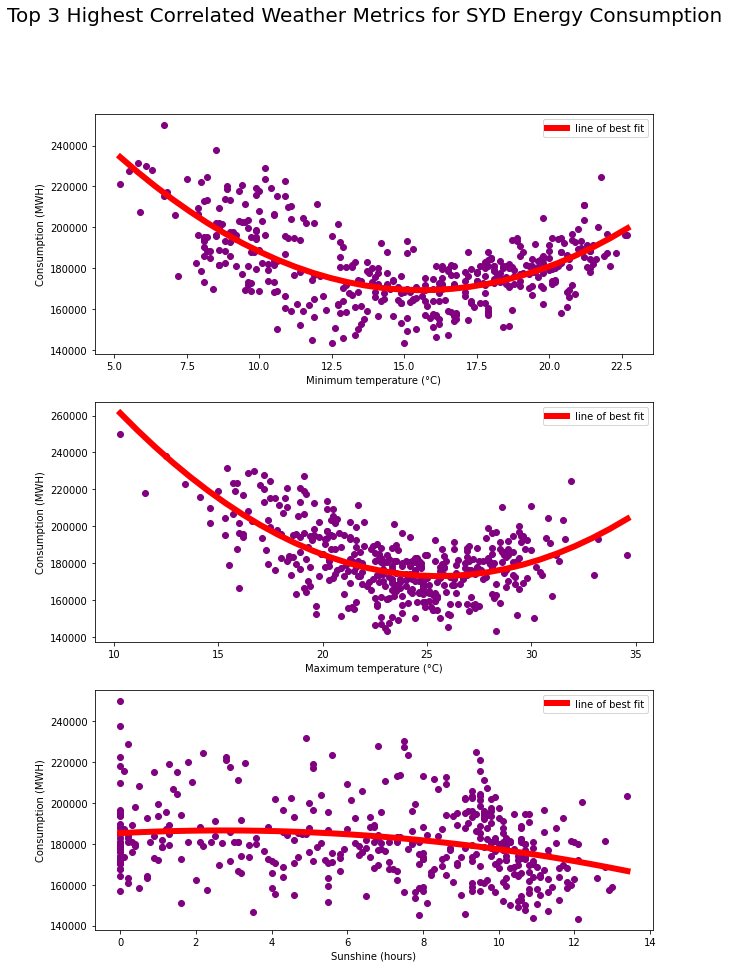

In [21]:
#create a subplot
plt.rcParams["figure.figsize"] = (10,15)
fig, ax = plt.subplots(3)

for i in range (3):

    ax[i].scatter(consumption_merged_data.iloc[:,i], consumption_merged_data['CONSUMPTION'], c = "purple")
    ax[i].set_xlabel(consumption_merged_data.columns[i])
    ax[i].set_ylabel("Consumption (MWH)")
    

    #draw line of best fit for actual value of y
    z = np.polyfit(consumption_merged_data.iloc[:,i], consumption_merged_data['CONSUMPTION'], 2)
    curve_1 = np.array(z)
    x = np.linspace(min(consumption_merged_data.iloc[:,i]),max(consumption_merged_data.iloc[:,i]),30)
    y_1 = [np.polyval(curve_1, i) for i in x]
    ax[i].plot(x,y_1, 'r', linewidth = 6, label = "line of best fit")

    #adding lengend for the graph
    ax[i].legend(loc = "upper right")


plt.suptitle('Top 3 Highest Correlated Weather Metrics for SYD Energy Consumption',fontsize=20)

plt.savefig('syd_selected_plot.png')
plt.show()
plt.close()

# Apply supervised Machine Learning

## Keep the feature that we selected and split the data into training and testing

In [22]:
features  = ['Minimum temperature (°C)', 'Maximum temperature (°C)', 'Sunshine (hours)']

X = consumption_merged_data[features]
Y = consumption_merged_data['CONSUMPTION']

## Create the train and test data and initialize the cross validation

In [23]:
#split the data into test and train
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3, random_state=10)

## K-NN Regression 

- For choosing the k number of the neighbor, we perform the model with different k and picking out the k value that gives the smallest in root mean squared error

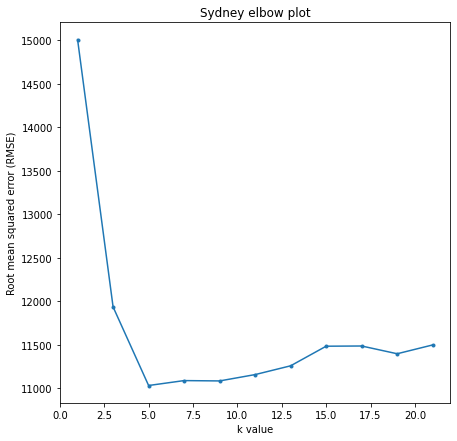

In [24]:
RMSE = []
for k in range(1,23,2):
    syd_knn_model = KNeighborsRegressor(n_neighbors=k)
    syd_knn_model.fit(X_train,Y_train)
    rmse = -cross_val_score(syd_knn_model, X_train, Y_train, scoring="neg_root_mean_squared_error", cv=10)
    RMSE.append(np.mean(rmse))

#create a subplot
plt.rcParams["figure.figsize"] = (7,7)
fig, ax = plt.subplots()

k = [i for i in range(1,23,2)]
ax.plot(k,RMSE, ".-")
ax.set_xlabel("k value")
ax.set_ylabel("Root mean squared error (RMSE)")
ax.set_title("Sydney elbow plot")

plt.savefig("Syd_elbow.png")
plt.show()
plt.close()


- According to the elbow method, we choose the k value for the KNN model is 9 which gives us the smallest root mean squared error.

In [25]:
syd_knn_model = KNeighborsRegressor(n_neighbors=5)
syd_knn_model.fit(X_train,Y_train)

KNeighborsRegressor()

## Prediction

In [26]:
y_predict = syd_knn_model.predict(X_test)

In [27]:
print('r2: ' , metrics.r2_score(Y_test, y_predict))
RMSE = math.sqrt(metrics.mean_squared_error(Y_test, y_predict))
print("RMSE: ",  RMSE)
print("Percentage of RMSE compare to average of actual value: ", round((RMSE/np.mean(Y_test))*100), "%")
MAE = metrics.mean_absolute_error(Y_test, y_predict)
print("MAE: ", MAE)
print("Percentage of error compare to average of actual value: ", round((MAE/np.mean(Y_test))*100), "%")

r2:  0.4017688215313737
RMSE:  12550.879481312773
Percentage of RMSE compare to average of actual value:  7 %
MAE:  10130.96305952347
Percentage of error compare to average of actual value:  6 %


## Observing y actual vs y test graph

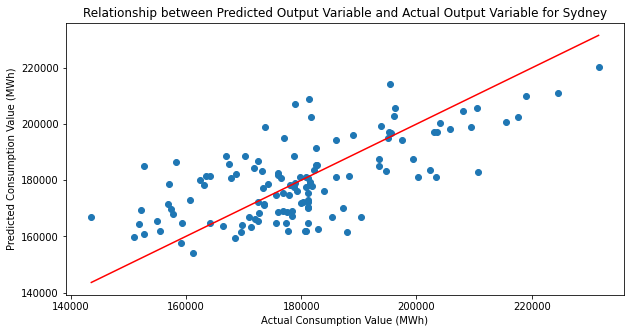

In [28]:
#create a subplot
plt.rcParams["figure.figsize"] = (10,5)
fig, ax = plt.subplots()

ax.scatter(Y_test, y_predict)

#plot the line y = x
x = np.linspace(min(Y_test), max(Y_test), 30)
ax.plot(x,x, 'r')


ax.set_xlabel("Actual Consumption Value (MWh)")
ax.set_ylabel("Predicted Consumption Value (MWh)")
ax.set_title('Relationship between Predicted Output Variable and Actual Output Variable for Sydney')

plt.savefig('Sample_Syd_ytestvstrain.png')
plt.show()
plt.close()

## Observing how well the prediction compare to the actual value of the consumption 

In [29]:
def observe_prediction(X_test, Y_test, y_predict, title, output_name):

    #create a subplot
    plt.rcParams["figure.figsize"] = (10,15)
    fig, ax = plt.subplots(3)


    for i in range (3):
        ax[i].scatter(X_test.iloc[:,i], Y_test, label = "Actual")
        ax[i].scatter(X_test.iloc[:,i], pd.Series(y_predict), label = "Predict")
        ax[i].set_xlabel(X_test.columns[i])
        ax[i].set_ylabel("Consumption")

        #adding lengend for the graph
        ax[i].legend(loc = "upper right")



    plt.suptitle(title,fontsize=20)

    plt.savefig(output_name)
    plt.show()
    plt.close()

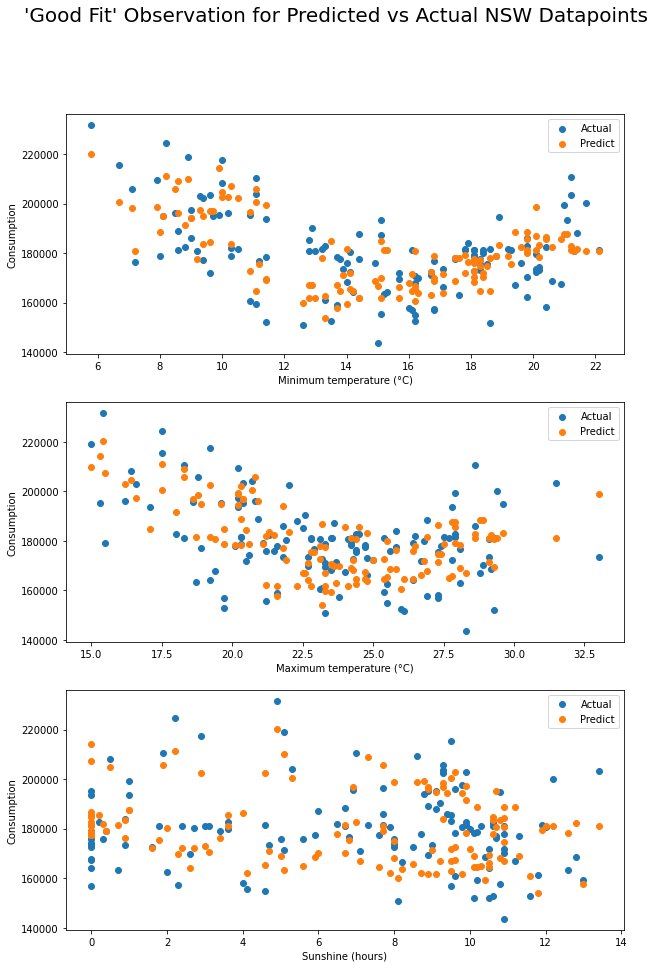

In [30]:
output_name = 'observing_predict_plot_syd.png'
title = "'Good Fit' Observation for Predicted vs Actual NSW Datapoints"
observe_prediction(X_test, Y_test, y_predict, title, output_name)

# Finding is there any relationship between the weather conditions and the demand at exactly particular time such as 9am or 3pm in the day

In [31]:
nsw_demand.head()

,REGION,SETTLEMENTDATE,TOTALDEMAND,PRICESURGE,Date,diff_time,CONSUMPTION
0,NSW1,2021/02/01 00:30:00,6693.67,False,2021-02-01,1800.0,3346.741289
1,NSW1,2021/02/01 01:00:00,6511.88,False,2021-02-01,1800.0,3255.848834
2,NSW1,2021/02/01 01:30:00,6275.03,False,2021-02-01,1800.0,3137.427150
3,NSW1,2021/02/01 02:00:00,6121.26,False,2021-02-01,1800.0,3060.544302
4,NSW1,2021/02/01 02:30:00,6123.13,False,2021-02-01,1800.0,3061.479276


## Take out the energy demand at 9am and 3pm

In [32]:
time_pattern = r'(\d{2}:\d{2}:\d{2})'
nsw_demand['Time'] = nsw_demand['SETTLEMENTDATE'].str.extract(time_pattern)

nsw_9am = nsw_demand.loc[nsw_demand['Time'] == "09:00:00"]
nsw_9am= nsw_9am.reset_index()
nsw_9am = nsw_9am.drop(['index'], axis = 1)
nsw_3pm = nsw_demand.loc[nsw_demand['Time'] == "15:00:00"]
nsw_3pm= nsw_3pm.reset_index()
nsw_3pm = nsw_3pm.drop(['index'], axis = 1)

C:\Users\Kevin\AppData\Local\Temp\ipykernel_2092\4153608748.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nsw_demand['Time'] = nsw_demand['SETTLEMENTDATE'].str.extract(time_pattern)


Before going to merge the original_merged_data with another new demand data which is 9am and 3pm demand, we need to drop out the columns related to demand. If we do not drop them, it will make the contradiction for the program

In [33]:
original_merged_data = original_merged_data.drop(['PRICESURGE','TOTALDEMAND', 'diff_time','CONSUMPTION'], axis =1)

## Finding the relationship with 9am

- Merge the 9am demand with the weather data (which is already pre_processed)

In [34]:
#merge the demand at 9am to the weather dataset which is already pre-processed
merged_9am_data = pd.merge(original_merged_data, nsw_9am, how='left')

#keeping 9am feature
feature_9am = []

for col in merged_9am_data:
    if '9am' in col:
        feature_9am.append(col)

#still keeping the totaldemand columns
feature_9am.append("TOTALDEMAND")
merged_9am_data = merged_9am_data[feature_9am]

#fill out some nan value due to the merge to the left 
#because the number of the date in weather data is more than demand data
merged_9am_data['TOTALDEMAND'] = merged_9am_data['TOTALDEMAND'].fillna(merged_9am_data['TOTALDEMAND'].mean())

merged_9am_data.head()

,9am Temperature (°C),9am relative humidity (%),9am cloud amount (oktas),9am wind direction,9am wind speed (km/h),9am MSL pressure (hPa),TOTALDEMAND
0,22.1,86,7.0,9.0,7.000000,1016.1,8002.00
1,19.1,87,7.0,13.0,17.000000,1010.5,7648.14
2,19.4,72,1.0,12.0,15.000000,1013.7,7171.17
3,21.5,88,6.0,0.0,15.884892,1013.4,7505.12
4,23.5,84,2.0,5.0,17.000000,1012.1,8213.26


### The relationship between weather condition and the demand is not linear

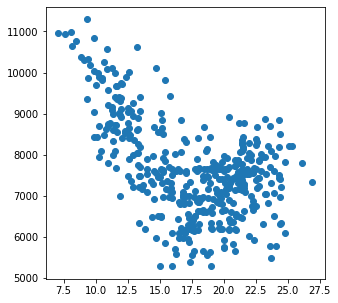

In [35]:
#create a subplot
plt.rcParams["figure.figsize"] = (5,5)
fig, ax = plt.subplots()

ax.scatter(merged_9am_data['9am Temperature (°C)'], merged_9am_data['TOTALDEMAND'])
plt.show()
plt.close()

## NMI for 9 am weather data 

In [36]:
equal_width = KBinsDiscretizer(n_bins=20, encode='ordinal', strategy='uniform')

discrete_9am_data = merged_9am_data.copy()
for name in merged_9am_data:
    
    discrete_9am_data[name] = equal_width.fit_transform(merged_9am_data[[name]])

corr = discrete_9am_data.corr(method=normalized_mutual_info_score)
corr.style.background_gradient(cmap='coolwarm')


,9am Temperature (°C),9am relative humidity (%),9am cloud amount (oktas),9am wind direction,9am wind speed (km/h),9am MSL pressure (hPa),TOTALDEMAND
9am Temperature (°C),1.000000,0.138243,0.105036,0.202353,0.131059,0.174067,0.239711
9am relative humidity (%),0.138243,1.000000,0.110768,0.132166,0.134465,0.132852,0.147463
9am cloud amount (oktas),0.105036,0.110768,1.000000,0.115582,0.091557,0.088261,0.094180
9am wind direction,0.202353,0.132166,0.115582,1.000000,0.159754,0.137773,0.137333
9am wind speed (km/h),0.131059,0.134465,0.091557,0.159754,1.000000,0.141306,0.133191
9am MSL pressure (hPa),0.174067,0.132852,0.088261,0.137773,0.141306,1.000000,0.131237
TOTALDEMAND,0.239711,0.147463,0.094180,0.137333,0.133191,0.131237,1.000000


The top 9 am Metric that is most highly correlated with energy demand is the '9am Temperature' measurement

### Performing Mutual Information for feature selection

In [37]:
# get our features and class label
features = discrete_9am_data[[x for x in discrete_9am_data]]
class_label = discrete_9am_data['TOTALDEMAND']

mi_arr = mutual_info_classif(X=features, y=class_label, discrete_features=True)
mi_value = []

for feature, mi in zip(features.columns, mi_arr):
    print(f'MI value for feature "{feature}": {mi:.4f}')
    mi_value.append((feature,mi))

MI value for feature "9am Temperature (°C)": 0.6553
MI value for feature "9am relative humidity (%)": 0.3973
MI value for feature "9am cloud amount (oktas)": 0.2184
MI value for feature "9am wind direction": 0.3459
MI value for feature "9am wind speed (km/h)": 0.3486
MI value for feature "9am MSL pressure (hPa)": 0.3515
MI value for feature "TOTALDEMAND": 2.6780


In [38]:
mi_value.sort(key= lambda x:x[1])
mi_value[-4:]

[('9am MSL pressure (hPa)', 0.3515149214236648),
 ('9am relative humidity (%)', 0.39730799294973046),
 ('9am Temperature (°C)', 0.655266059849368),
 ('TOTALDEMAND', 2.6780119066209567)]

Selected Feature for Machine Learning are:
- 9am MSL pressure (hPa)
- 9am relative humidity (%)
- 9am Temperature (°C)

### Apply KNN regressor for 9am

In [39]:
#keep the selected feature in the dataframe
features_9am  = ['9am MSL pressure (hPa)', '9am relative humidity (%)', '9am Temperature (°C)']

X_9am = merged_9am_data[features_9am]
Y_9am = merged_9am_data['TOTALDEMAND']

In [40]:
#split the data into test and train
X_9am_train, X_9am_test, Y_9am_train, Y_9am_test = train_test_split(X_9am,Y_9am, test_size=0.3, random_state=20)

- For choosing the k number of the neighbor, we perform the model with different k and picking out the k value that gives the smallest in root mean squared error


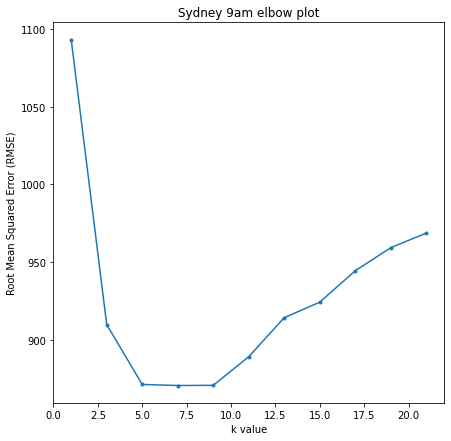

In [41]:
RMSE_9am = []
for k in range(1,23,2):
    syd_9am_knn_model = KNeighborsRegressor(n_neighbors=k)
    syd_9am_knn_model.fit(X_9am_train,Y_9am_train)
    rmse_9am = -cross_val_score(syd_9am_knn_model, X_9am_train, Y_9am_train, scoring="neg_root_mean_squared_error", cv=10)
    RMSE_9am.append(np.mean(rmse_9am))

#create a subplot
plt.rcParams["figure.figsize"] = (7,7)
fig, ax = plt.subplots()

k = [i for i in range(1,23,2)]

ax.plot(k,RMSE_9am, ".-")
ax.set_xlabel("k value")
ax.set_ylabel("Root Mean Squared Error (RMSE)")
ax.set_title('Sydney 9am elbow plot')

plt.show()
plt.close()

- According to the elbow method, we choose the k value for the KNN model is 5 which gives us the smallest root mean squared error.


In [42]:
syd_9am_knn_model = KNeighborsRegressor(n_neighbors=5)
syd_9am_knn_model.fit(X_9am_train,Y_9am_train)

y_9am_predict = syd_9am_knn_model.predict(X_9am_test)
print('r2: ', metrics.r2_score(Y_9am_test, y_9am_predict))
RMSE_9am = math.sqrt(metrics.mean_squared_error(Y_9am_test, y_9am_predict))
print("RMSE: ",  RMSE_9am)
print("Percentage of RMSE compare to average of actual value: ", round((RMSE_9am/np.mean(Y_9am_test))*100), "%")
MAE_9am = metrics.mean_absolute_error(Y_9am_test, y_9am_predict)
print("MAE: ", MAE_9am)
print("Percentage of error compare to average of actual value: ", round((MAE_9am/np.mean(Y_9am_test))*100), "%")

r2:  0.3837131108245597
RMSE:  888.4137964151752
Percentage of RMSE compare to average of actual value:  12 %
MAE:  698.440468902439
Percentage of error compare to average of actual value:  9 %


## Observing y actual vs y test graph for 9am data


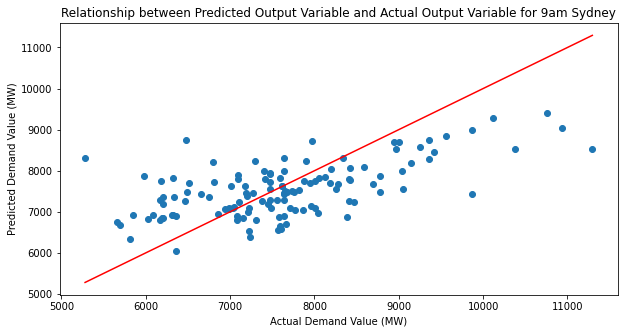

In [43]:
#create a subplot
plt.rcParams["figure.figsize"] = (10,5)
fig, ax = plt.subplots()

ax.scatter(Y_9am_test, y_9am_predict)

#plot the line y = x
x = np.linspace(min(Y_9am_test), max(Y_9am_test), 30)
ax.plot(x,x, 'r')

ax.set_xlabel("Actual Demand Value (MW)")
ax.set_ylabel("Predicted Demand Value (MW)")
ax.set_title('Relationship between Predicted Output Variable and Actual Output Variable for 9am Sydney')


plt.show()
plt.close()

## Observing how well the prediction compare to the actual value of the demand for 9am weather condition 


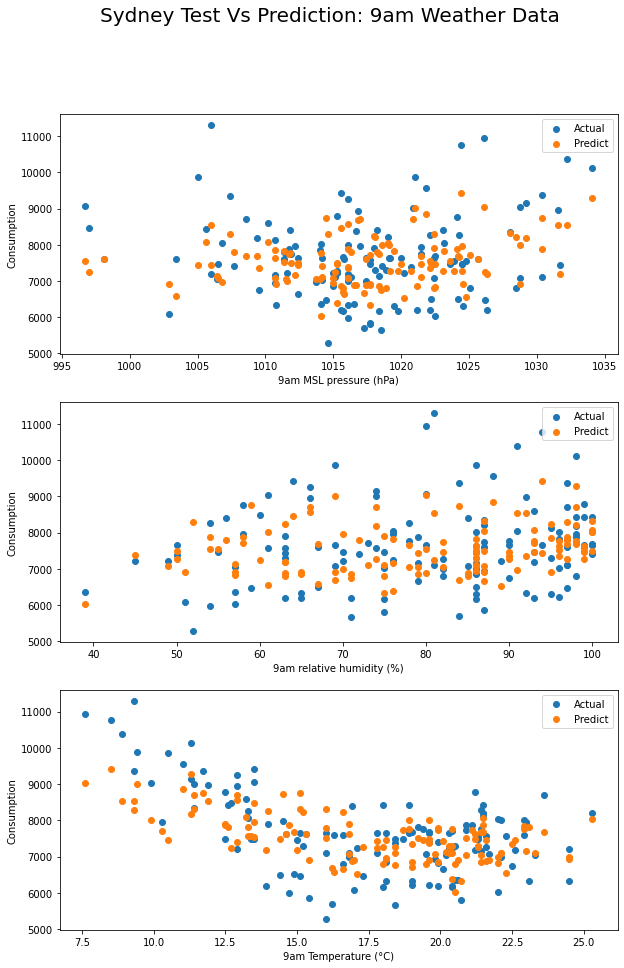

In [44]:
output_name = 'observing_predict_plot_9am_syd.png'
title = 'Sydney Test Vs Prediction: 9am Weather Data'
observe_prediction(X_9am_test, Y_9am_test, y_9am_predict, title, output_name)

## Finding the relationship with 3pm


- Merge the 3pm demand with the weather data (which is already pre_processed)


In [45]:
#merge the demand at 9am to the weather dataset which is already pre-processed
merged_3pm_data = pd.merge(original_merged_data, nsw_3pm, how='left')

#keeping 9am feature
feature_3pm = []

for col in merged_3pm_data:
    if '3pm' in col:
        feature_3pm.append(col)

#still keeping the totaldemand columns
feature_3pm.append("TOTALDEMAND")
merged_3pm_data = merged_3pm_data[feature_3pm]

#fill out some nan value due to the merge to the left 
#because the number of the date in weather data is more than demand data
merged_3pm_data['TOTALDEMAND'] = merged_3pm_data['TOTALDEMAND'].fillna(merged_3pm_data['TOTALDEMAND'].mean())

merged_3pm_data.head()

,3pm Temperature (°C),3pm relative humidity (%),3pm cloud amount (oktas),3pm wind direction,3pm wind speed (km/h),3pm MSL pressure (hPa),TOTALDEMAND
0,28.3,68,1,3.0,17.0,1012.3,8570.35
1,23.2,60,2,10.0,24.0,1010.5,7359.20
2,24.7,56,5,3.0,17.0,1012.6,7172.79
3,27.7,62,5,5.0,30.0,1010.0,8828.54
4,28.1,71,2,5.0,33.0,1009.0,9372.00


### The relationship between weather condition and the demand is not linear


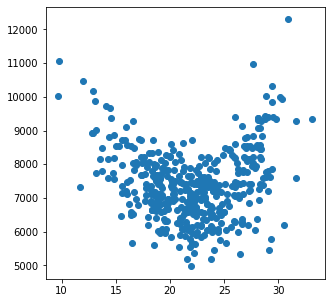

In [46]:
#create a subplot
plt.rcParams["figure.figsize"] = (5,5)
fig, ax = plt.subplots()

ax.scatter(merged_3pm_data['3pm Temperature (°C)'], merged_3pm_data['TOTALDEMAND'])

plt.show()
plt.close()

### Finding NMI for 3pm 

In [47]:
equal_width = KBinsDiscretizer(n_bins=20, encode='ordinal', strategy='uniform')
#plot the discrete data 
discrete_3pm_data = merged_3pm_data.copy()
for name in merged_3pm_data:
    
    discrete_3pm_data[name] = equal_width.fit_transform(merged_3pm_data[[name]])

corr = discrete_3pm_data.corr(method=normalized_mutual_info_score)
corr.style.background_gradient(cmap='coolwarm')


,3pm Temperature (°C),3pm relative humidity (%),3pm cloud amount (oktas),3pm wind direction,3pm wind speed (km/h),3pm MSL pressure (hPa),TOTALDEMAND
3pm Temperature (°C),1.000000,0.185343,0.083953,0.162175,0.126263,0.161377,0.195412
3pm relative humidity (%),0.185343,1.000000,0.200867,0.182882,0.150773,0.149987,0.161895
3pm cloud amount (oktas),0.083953,0.200867,1.000000,0.068898,0.074759,0.081753,0.104536
3pm wind direction,0.162175,0.182882,0.068898,1.000000,0.127329,0.133941,0.121260
3pm wind speed (km/h),0.126263,0.150773,0.074759,0.127329,1.000000,0.137024,0.099587
3pm MSL pressure (hPa),0.161377,0.149987,0.081753,0.133941,0.137024,1.000000,0.136346
TOTALDEMAND,0.195412,0.161895,0.104536,0.121260,0.099587,0.136346,1.000000


The 3pm metric with the highest correlation to demand is the '3pm temperature'

### Performing Mutual Information for feature selection


In [48]:
# get our features and class label
features = discrete_3pm_data[[x for x in discrete_3pm_data]]
class_label = discrete_3pm_data['TOTALDEMAND']

mi_arr = mutual_info_classif(X=features, y=class_label, discrete_features=True)
mi_value = []

for feature, mi in zip(features.columns, mi_arr):
    print(f'MI value for feature "{feature}": {mi:.4f}')
    mi_value.append((feature,mi))

MI value for feature "3pm Temperature (°C)": 0.4982
MI value for feature "3pm relative humidity (%)": 0.4204
MI value for feature "3pm cloud amount (oktas)": 0.2310
MI value for feature "3pm wind direction": 0.3021
MI value for feature "3pm wind speed (km/h)": 0.2469
MI value for feature "3pm MSL pressure (hPa)": 0.3458
MI value for feature "TOTALDEMAND": 2.4307


In [49]:
mi_value.sort(key= lambda x:x[1])
mi_value[-4:]

[('3pm MSL pressure (hPa)', 0.3458307741532521),
 ('3pm relative humidity (%)', 0.4203838166503928),
 ('3pm Temperature (°C)', 0.49819057070260564),
 ('TOTALDEMAND', 2.4306944750851587)]

Selected Feature for Machine Learning are:
- 3pm MSL pressure (hPa)
- 3pm relative humidity (%)
- 3pm Temperature (°C)

### Apply KNN regressor for 3pm


In [50]:
features_3pm  = ['3pm MSL pressure (hPa)', '3pm relative humidity (%)', '3pm Temperature (°C)']

X_3pm = merged_3pm_data[features_3pm]
Y_3pm = merged_3pm_data['TOTALDEMAND']

In [51]:
#split the data into test and train
X_3pm_train, X_3pm_test, Y_3pm_train, Y_3pm_test = train_test_split(X_3pm,Y_3pm, test_size=0.3, random_state=21)

- For choosing the k number of the neighbor, we perform the model with different k and picking out the k value that gives the smallest in root mean squared error


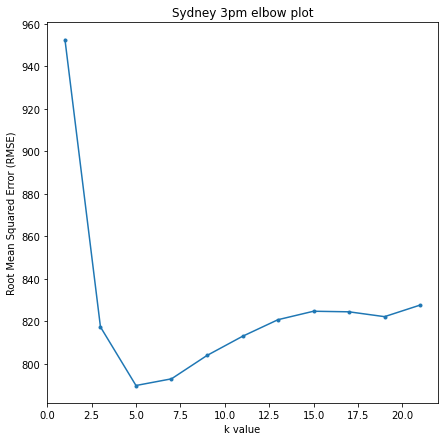

In [52]:
RMSE_3pm = []
for k in range(1,23,2):
    syd_3pm_knn_model = KNeighborsRegressor(n_neighbors=k)
    syd_3pm_knn_model.fit(X_3pm_train,Y_3pm_train)
    rmse_3pm = -cross_val_score(syd_3pm_knn_model, X_3pm_train, Y_3pm_train, scoring="neg_root_mean_squared_error", cv=10)
    RMSE_3pm.append(np.mean(rmse_3pm))

#create a subplot
plt.rcParams["figure.figsize"] = (7,7)
fig, ax = plt.subplots()

k = [i for i in range(1,23,2)]

ax.plot(k,RMSE_3pm, ".-")
ax.set_xlabel("k value")
ax.set_ylabel("Root Mean Squared Error (RMSE)")
ax.set_title('Sydney 3pm elbow plot')

plt.show()
plt.close()

- According to the elbow method, we choose the k value for the KNN model is 7 which gives us the smallest root mean squared error.


In [53]:
syd_3pm_knn_model = KNeighborsRegressor(n_neighbors=5)
syd_3pm_knn_model.fit(X_3pm_train,Y_3pm_train)

y_3pm_predict = syd_3pm_knn_model.predict(X_3pm_test)
print('r2: ', metrics.r2_score(Y_3pm_test, y_3pm_predict))
RMSE_3pm = math.sqrt(metrics.mean_squared_error(Y_3pm_test, y_3pm_predict))
print("RMSE: ",  RMSE_3pm)
print("Percentage of RMSE compare to average of actual value: ", round((RMSE_3pm/np.mean(Y_3pm_test))*100), "%")
MAE_3pm = metrics.mean_absolute_error(Y_3pm_test, y_3pm_predict)
print("MAE: ", MAE_3pm)
print("Percentage of error compare to average of actual value: ", round((MAE_3pm/np.mean(Y_3pm_test))*100), "%")

r2:  0.2826018535540833
RMSE:  948.2514651419186
Percentage of RMSE compare to average of actual value:  13 %
MAE:  725.0236640243902
Percentage of error compare to average of actual value:  10 %


## Observing y actual vs y test graph for 3pm data


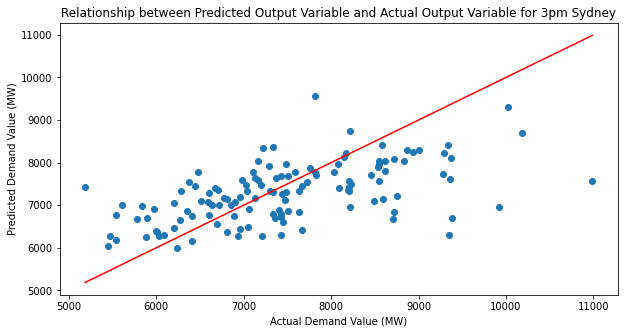

In [54]:
#create a subplot
plt.rcParams["figure.figsize"] = (10,5)
fig, ax = plt.subplots()

ax.scatter(Y_3pm_test, y_3pm_predict)

#plot the line y = x
x = np.linspace(min(Y_3pm_test), max(Y_3pm_test), 30)
ax.plot(x,x, 'r')

ax.set_xlabel("Actual Demand Value (MW)")
ax.set_ylabel("Predicted Demand Value (MW)")
ax.set_title('Relationship between Predicted Output Variable and Actual Output Variable for 3pm Sydney')


plt.show()
plt.close()

## Observing how well the prediction compare to the actual value of the demand for 3pm weather condition 


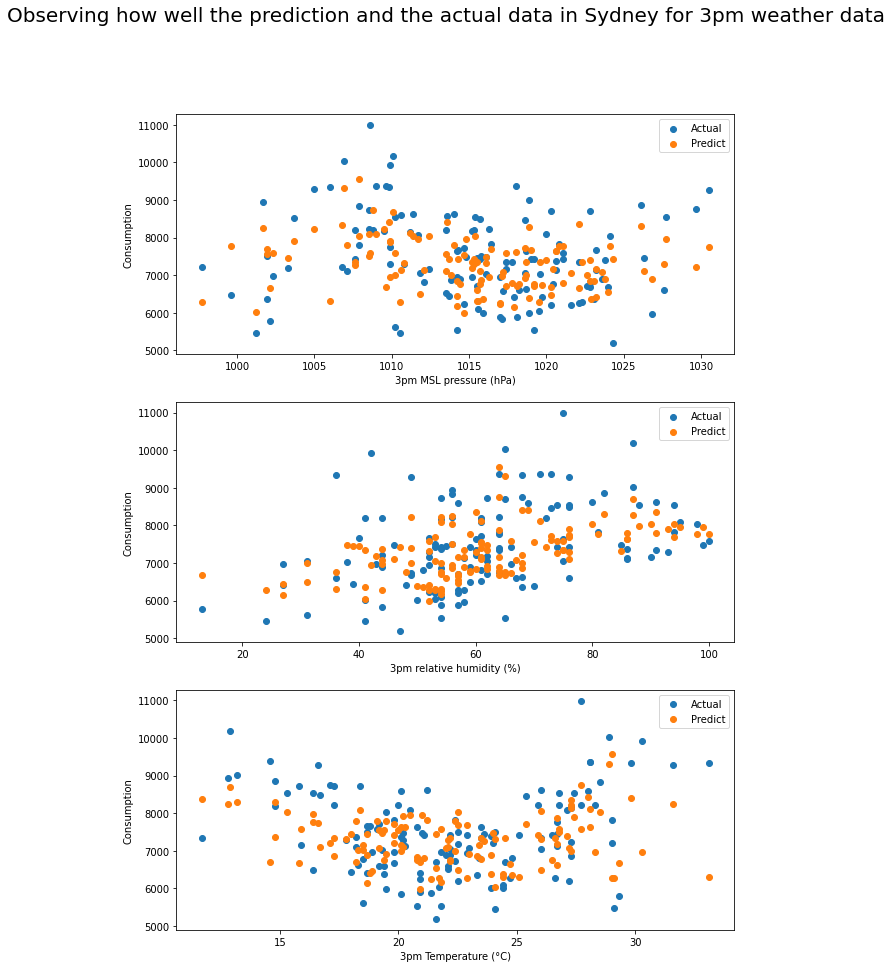

In [55]:
output_name = 'observing_predict_plot_3pm_syd.png'
title = 'Observing how well the prediction and the actual data in Sydney for 3pm weather data'
observe_prediction(X_3pm_test, Y_3pm_test, y_3pm_predict, title, output_name)